# Nuage Compta

In [4]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from PIL import Image

import matplotlib.pyplot as plt

import modules.images.utils as im


In [5]:
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)

TRAIN_DATA_DIR = '../data/dataset'
TRAIN_IMAGE_SIZE = 28
TRAIN_BATCH_SIZE = 32

train_generator = image_data_generator.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE),
    batch_size=TRAIN_BATCH_SIZE,
    class_mode='categorical',
    subset='training')
 
validation_generator = image_data_generator.flow_from_directory(
    TRAIN_DATA_DIR, # same directory as training data
    target_size=(TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE),
    batch_size=TRAIN_BATCH_SIZE,
    class_mode='categorical',
    subset='validation')

Found 18031 images belonging to 2 classes.
Found 4507 images belonging to 2 classes.


In [33]:
model = Sequential()

model.add(Conv2D(32, kernel_size=7, activation='relu', padding='same', input_shape=(28,28,3))) # 5 ou 7 au dessus de 128
model.add(Conv2D(64, kernel_size=7, activation='relu', padding='same'))

model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        4736      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        100416    
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 100354    
Total params: 205,506
Trainable params: 205,506
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

training = model.fit_generator(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
564/564 [==============================] - 63s 113ms/step - loss: 0.9815 - accuracy: 0.9829 - val_loss: 0.0376 - val_accuracy: 0.9942
Epoch 2/10
564/564 [==============================] - 85s 151ms/step - loss: 0.0141 - accuracy: 0.9955 - val_loss: 0.0023 - val_accuracy: 0.9982
Epoch 3/10
564/564 [==============================] - 87s 154ms/step - loss: 0.0143 - accuracy: 0.9965 - val_loss: 6.3441e-06 - val_accuracy: 0.9896
Epoch 4/10
564/564 [==============================] - 69s 123ms/step - loss: 0.0220 - accuracy: 0.9952 - val_loss: 3.4126e-04 - val_accuracy: 0.9969
Epoch 5/10
564/564 [==============================] - 81s 144ms/step - loss: 0.0062 - accuracy: 0.9982 - val_loss: 0.0017 - val_accuracy: 0.9962
Epoch 6/10
564/564 [==============================] - 78s 138ms/step - loss: 0.1264 - accuracy: 0.9921 - val_loss: 4.4152e-09 - val_accuracy: 0.9945
Epoch 7/10
564/564 [==============================] - 73s 129ms/step - loss: 0.0367 - accuracy: 0.9973 - val_loss: 0.0

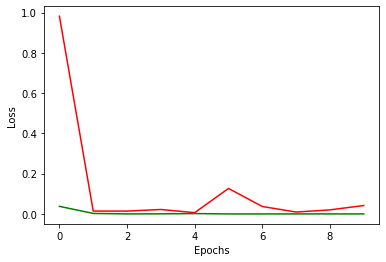

In [35]:
plt.plot(training.history['loss'], color='red', label='Training loss')
plt.plot(training.history['val_loss'],  color='green', label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

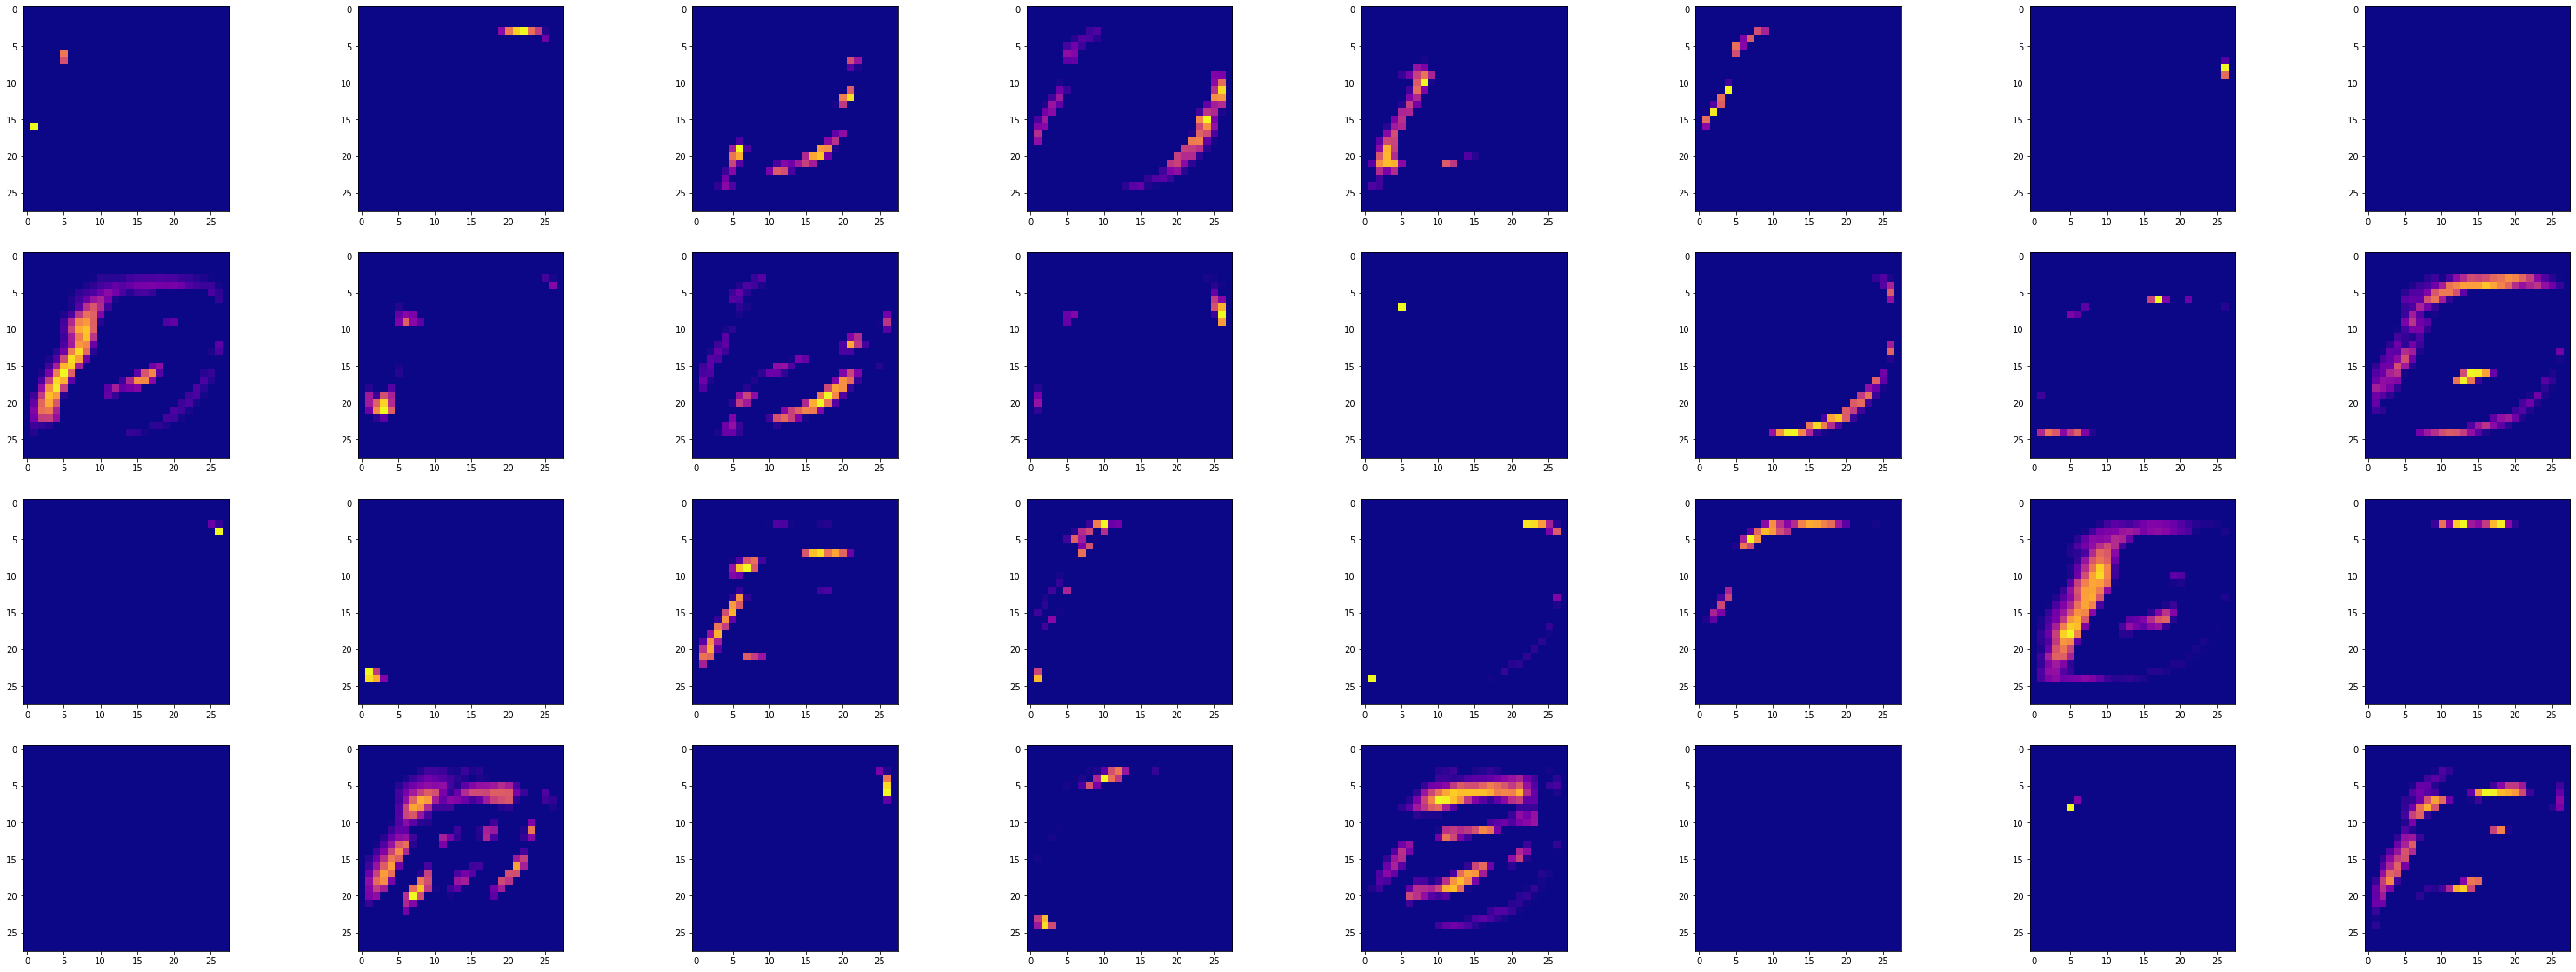

In [38]:
from keras.models import Model
from keras.preprocessing import image
import numpy as np

layer_outputs = [layer.output for layer in model.layers]

test_image = "../data/dataset/B/B-0.png"

# Le chargement de l'image doit être augmenté puisque notre model prend des lots d'images.
img = image.load_img(test_image, target_size=(28,28, 1))
img_arr = image.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)

activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_arr)

def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*13.5,col_size*2.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='plasma')
            activation_index += 1

display_activation(activations, 8, 4, 0)

## Extraction des images

La première partie consiste à extraire les lettres de l'image de test

In [3]:
import cv2
import numpy as np

image = cv2.imread("test.jpeg")

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
cv2.imwrite("../data/staging/gray.jpeg", gray)

# Permet de convertir l'image en blanc sur fond noir. Etape nécessaire pour la méthode findContours de OpenCV et par rapport à notre cible
_, threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV) 
cv2.imwrite("../data/staging/threshold.jpeg", threshold)

# Copie de l'image sur laquelle on va travailler.
target_image = threshold.copy()

# Detection des contours. On demande de prendre que les points externes avec RETR_EXTERNAL et d'optimiser le nombre de points avec CHAIN_APPROX_SIMPLE
contours = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

roi_index = 0

for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)

    if w < 50 and h < 50:
        continue

    # Extraction de la lettre dans l'image
    roi = target_image[y:y+h, x:x+w]
    cv2.imwrite('../data/staging/extract/region_{}.jpeg'.format(roi_index), roi)

    # Resize de la lettre pour être en 20x20 en gardant le ratio
    r_img = im.resize_image(roi)
    cv2.imwrite('../data/staging/resize/region_resize_{}.jpeg'.format(roi_index), r_img)

    # Ajout du padding de 4
    p_img= cv2.copyMakeBorder(r_img.copy(),4,4,4,4,cv2.BORDER_CONSTANT)
    cv2.imwrite('../data/out/region_padded_{}.jpeg'.format(roi_index), p_img)

    roi_index += 1